In [81]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import mode
import math
%matplotlib inline


In [82]:
matches = pd.read_csv('matches.csv')
delivery = pd.read_csv('deliveries.csv')
match_ids = matches[matches.season >= 2016]['id'].unique()
matches1 = matches[(matches.season >= 2016) & (matches['result']=='normal')]
matches1 = matches1.drop(['player_of_match','venue','umpire1','umpire2','umpire3', 'dl_applied', 'season', 'city', 'date', 'result'], axis=1)
matches1.dropna(inplace=True)

In [83]:
def team_correction(row):
    row = row.strip()
    if row == 'Delhi Daredevils':
        return 'Delhi Capitals'
    if row == 'Rising Pune Supergiants':
        return 'Rising Pune Supergiant'
    return row

for col in ['team1', 'team2', 'winner', 'toss_winner']:
    matches1[col] = matches1[col].apply(team_correction)
    

In [84]:
team_1 = 'Rajasthan Royals'
team_2 = 'Mumbai Indians'

# Winning Probability of Teams

Text(0.5, 1.0, 'MI Total Runs Score Stats Per Count')

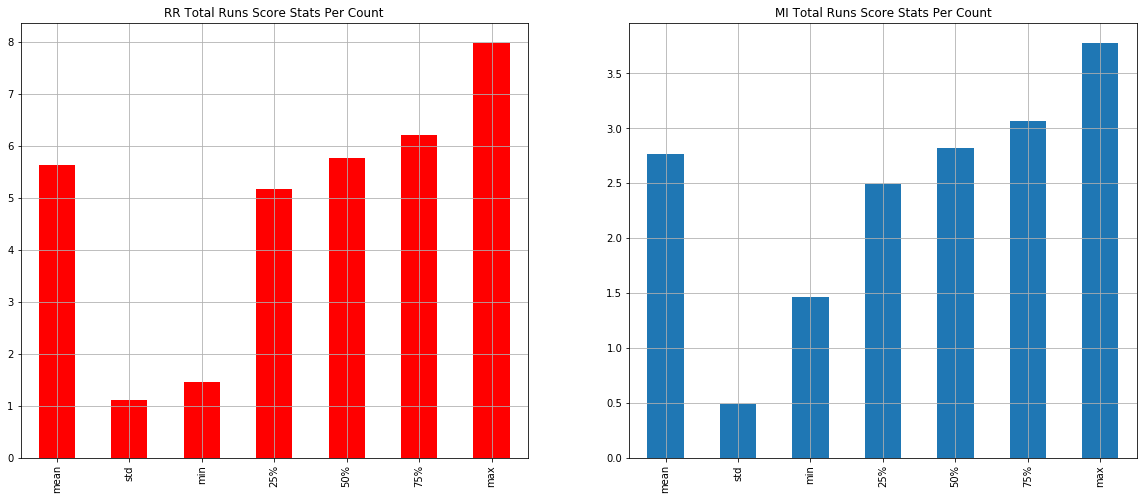

In [98]:
fig, ax = plt.subplots(1,2, figsize=(20,8))
rr_runs = delivery[delivery['batting_team']==team_1].groupby('match_id').sum()['total_runs']
mi_runs = delivery[delivery['batting_team']==team_2].groupby('match_id').sum()['total_runs']
(rr_runs.describe()[1:]/rr_runs.describe()[0]).plot(ax=ax[0], kind='bar', grid=True, color='red')
(mi_runs.describe()[1:]/mi_runs.describe()[0]).plot(ax=ax[1], kind='bar', grid=True)
ax[0].set_title("RR Total Runs Score Stats Per Count")
ax[1].set_title("MI Total Runs Score Stats Per Count")

In [86]:
delivery = delivery[delivery.match_id.apply(lambda x: True if x in match_ids else False)]
for col in ['batting_team', 'bowling_team']:
    delivery[col] = delivery[col].apply(team_correction)

delivery.fillna(0, inplace=True)
delivery['player_dismissed'] = delivery['player_dismissed'].apply(lambda x: 0 if x==0 else 1)

delivery['batsman_runs'] = delivery['batsman_runs'].apply(lambda x: x-1 if ((x==7) or (x==5)) else x)

# BIS

In [87]:
mi_team = ['RG Sharma', 'Q de Kock', 'SA Yadav', 'Ishan Kishan', 'HH Pandaya', 'KH Pandaya', 'NM Coulter-Nile', 'RD Chahar', 'JJ Bumrah', 'TA Boult']
rr_team = ['BA Stokes', 'RV Uthappa', 'SV Samson', 'SPD Smith', 'JC Buttler', 'R Parag', 'R Tewatia', 'J Archer', 'AS Rajpoot', 'S Gopal', '']

In [88]:
batsman_bis = list()
for batsman in (mi_team+rr_team):
    for match_id in delivery[(delivery['batsman']==batsman)]['match_id'].unique():
        batsman_runs = delivery[(delivery['batsman']==batsman) & (delivery['match_id']==match_id)]['batsman_runs'].sum()
        boundaries_runs = delivery[(delivery['batsman']==batsman) & (delivery['match_id']==match_id) & (delivery['batsman_runs'].isin([4, 6]))]['batsman_runs'].sum()
        single_runs = delivery[(delivery['batsman']==batsman) & (delivery['match_id']==match_id) & (delivery['batsman_runs'].isin([1, 2, 3]))]['batsman_runs'].sum()
        total_balls =  delivery[(delivery['batsman']==batsman) & (delivery['match_id']==match_id)]['batsman_runs'].count()
        if total_balls>=10:
            bis = (batsman_runs + boundaries_runs - (0.5*single_runs))/total_balls
            batsman_bis.append([batsman, bis])
            
bis_batsman = pd.DataFrame(data=batsman_bis)
bis_batsman['Team'] = bis_batsman[0].apply(lambda x: 'RR' if x in rr_team else 'MI')

Text(0.5, 1.0, 'BIS of MI Batsman')

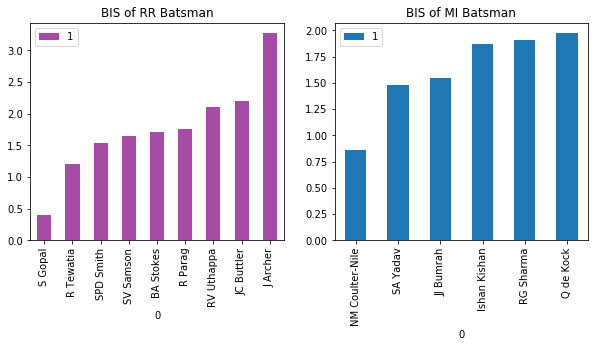

In [89]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
bis_batsman[bis_batsman['Team']=='RR'].groupby(0).median().sort_values(by=1).plot(ax=ax[0], kind='bar', color='purple', alpha=0.7)
bis_batsman[bis_batsman['Team']=='MI'].groupby(0).median().sort_values(by=1).plot(ax=ax[1], kind='bar')
ax[0].set_title("BIS of RR Batsman")
ax[1].set_title("BIS of MI Batsman")

# Best No. of Runs by boundaries/Total Runs

In [90]:
batsman_ratio = list()
for batsman in (mi_team+rr_team):
    for match_id in delivery[(delivery['batsman']==batsman)]['match_id'].unique():
        batsman_runs = delivery[(delivery['batsman']==batsman) & (delivery['match_id']==match_id)]['batsman_runs'].sum()
        boundaries_runs = delivery[(delivery['batsman']==batsman) & (delivery['match_id']==match_id) & (delivery['batsman_runs'].isin([4, 6]))]['batsman_runs'].sum()
        if batsman_runs!=0:
            ratio = boundaries_runs/batsman_runs
            batsman_ratio.append([batsman, ratio])
            
ratio_batsman = pd.DataFrame(data=batsman_ratio)
ratio_batsman.head()

,0,1
0,RG Sharma,0.00
1,RG Sharma,0.00
2,RG Sharma,0.00
3,RG Sharma,0.45
4,RG Sharma,0.00


Text(0.5, 1.0, ' Runs by Boundaries to Total Runs Scored Ratio')

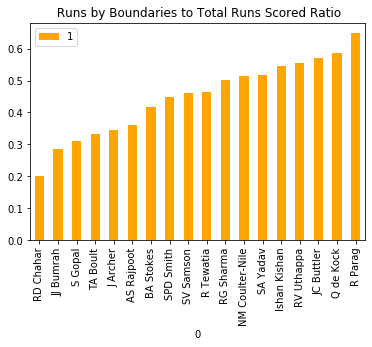

In [99]:
ratio_batsman.groupby(0).mean().sort_values(by=1).plot(kind='bar', color='orange')
plt.title(" Runs by Boundaries to Total Runs Scored Ratio")

# Difference of balls more/less to reach 100 

In [92]:
mi_century = list()
for match_id in delivery[(delivery['batting_team']==team_2)]['match_id'].unique():
    balls = 0
    runs = 0
    for run in delivery[(delivery['batting_team']==team_2) & (delivery['match_id']==match_id)]['total_runs']:
        balls += 1
        runs += run
        
        if runs in range(100, 106):
            break
    mi_century.append([match_id, runs, balls])
    
mi_100 = pd.DataFrame(data=mi_century, columns=['match_id', 'Runs', 'Balls'])
mi_100['Balls'].describe()

count     61.000000
mean      80.573770
std       15.809764
min       49.000000
25%       72.000000
50%       78.000000
75%       89.000000
max      127.000000
Name: Balls, dtype: float64

In [93]:
rr_century = list()
for match_id in delivery[(delivery['batting_team']==team_1)]['match_id'].unique():
    balls = 0
    runs = 0
    for run in delivery[(delivery['batting_team']==team_1) & (delivery['match_id']==match_id)]['total_runs']:
        balls += 1
        runs += run
        
        if runs in range(100, 106):
            break
    rr_century.append([match_id, runs, balls])
    
rr_100 = pd.DataFrame(data=rr_century, columns=['match_id', 'Runs', 'Balls'])
rr_100['Balls'].describe()

count     29.000000
mean      73.000000
std       14.367622
min       20.000000
25%       67.000000
50%       73.000000
75%       78.000000
max      106.000000
Name: Balls, dtype: float64

Text(0.5, 1.0, 'RR balls to score 100 Histogram')

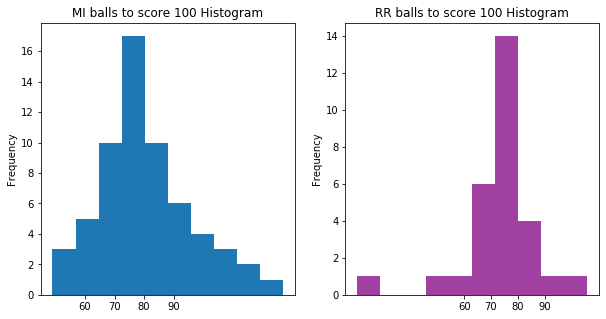

In [94]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
mi_100['Balls'].plot(ax=ax[0], kind='hist')
rr_100['Balls'].plot(ax=ax[1], kind='hist', color='purple', alpha=0.75)
ax[0].set_xticks([60, 70, 80, 90])
ax[1].set_xticks([60, 70, 80, 90])
ax[0].set_title("MI balls to score 100 Histogram")
ax[1].set_title("RR balls to score 100 Histogram")

In [95]:
print("Difference between mean number of balls taken to score 100 for teams:", (mi_100['Balls'].mean() - rr_100['Balls'].mean()))
print("Difference between median number of balls taken to score 100 for teams:", (mi_100['Balls'].median() - rr_100['Balls'].median()))
print("The histogram also suggests that the difference between balls is not more than 10 less/more.")

Difference between mean number of balls taken to score 100 for teams: 7.573770491803273
Difference between median number of balls taken to score 100 for teams: 5.0
The histogram also suggests that the difference between balls is not more than 10 less/more.


# BIS

In [96]:
bowlers_bls = list()
bowlers = list()
for bowler in (mi_team+rr_team):
    for match_id in delivery[(delivery['bowler']==bowler)]['match_id'].unique():
        match = delivery[(delivery['bowler']== bowler) & (delivery['match_id']==match_id)]
        wickets = len(match[match['player_dismissed']==1])
        boundaries = len(match[match['batsman_runs'].isin([4,6])])  
        dot_balls = len(match[(match['total_runs']==0)])
        runs = sum(match[match['batsman_runs'].isin([4,6])]['batsman_runs'])
        balls = len(match)
        if (balls >= 6) & (boundaries>0) & ((balls - dot_balls*2.5)!=0):
            bls = ((wickets + dot_balls*2) - (runs/boundaries))/(balls - dot_balls*2.5)
            bowlers.append(bowler)
            bowlers_bls.append(bls)
         
        
bls = pd.DataFrame(index=bowlers, data=bowlers_bls, columns=['BLS']).reset_index()
bls['Team'] = bls['index'].apply(lambda x: 'RR' if x in rr_team else 'MI')

Text(0.5, 1.0, 'BLS of MI Bowlers')

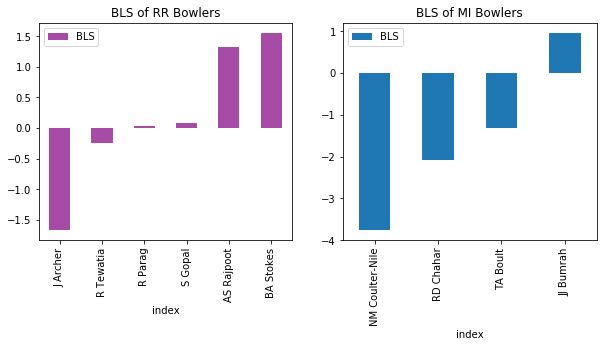

In [97]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
bls[bls['Team']=='RR'].groupby('index').mean().sort_values(by='BLS').plot(ax=ax[0], kind='bar', color='purple', alpha=0.7)
bls[bls['Team']=='MI'].groupby('index').mean().sort_values(by='BLS').plot(ax=ax[1], kind='bar')
ax[0].set_title("BLS of RR Bowlers")
ax[1].set_title("BLS of MI Bowlers")

# Summary

- Using central tendency measures, the scores per match by both the teams were compared. Using score comparison, the chances of winning of RR is high.
- Total runs, boundaries, boundaries run, and total balls faced by the batsman per match was calculated and put into BIS formula to take out BIS for batsman for each of their matches and the median value of BIS was compared. 
- Boundaries runs and total runs per batsman per match was calculated and mean values were compared.
- The number of balls needed for the teams to score 100 was calculated for each match played so far, and balls histogram and mean, median values suggested the same range. 
- For BLS, the wickets taken, dot balls bowled, total runs by boundaries, total boundaries, total balls bowled per bowler per match was calculated and put into BLS formula. 